In [28]:
import pandas as pd
import pandahouse
import seaborn as sns
import numpy as np
from scipy import stats #статистика

In [29]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

Эксперимент проходил с 2023-06-30 по 2023-07-06 включительно.
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
### Основная гипотеза АВ-теста заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

In [30]:
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-06-30' and '2023-07-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [31]:
df = pandahouse.read_clickhouse(query, connection=connection)

### Сделаем графики в seaborn и посмотрим на данные глазами

In [32]:
sns.set(rc={'figure.figsize':(18,10)})

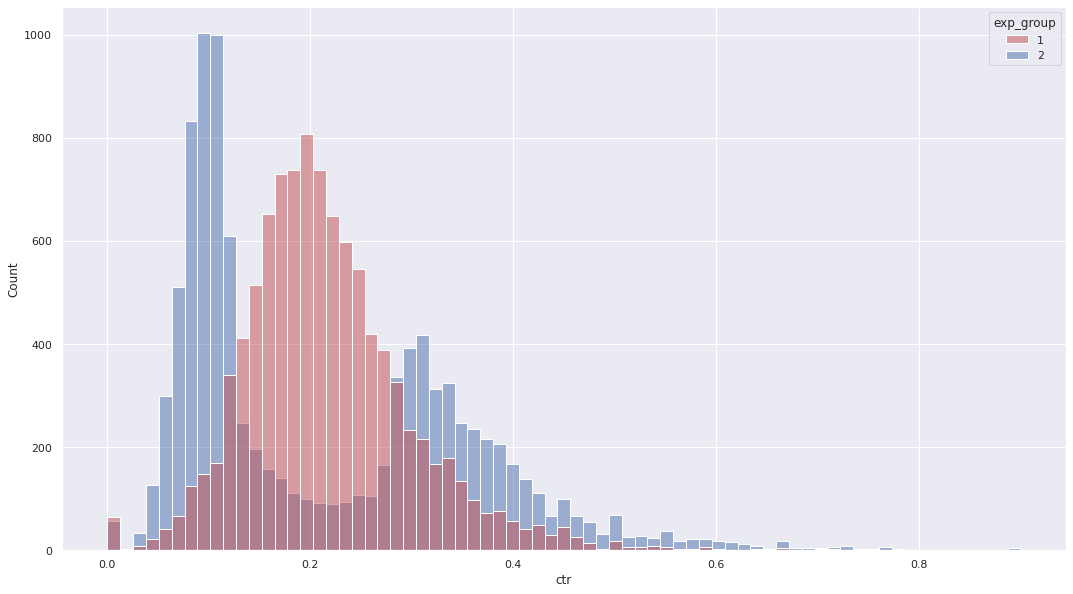

In [33]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Характер распределения метрики ctr значительно изменился. Наблюдается два характерных пика (двухгорбовое распределение).

Поэтому t-критерий Стьюдента и сглаженный ctr использовать не будем, так как вероятно будет некорректный результат.

### Критерий Манна-Уитни

In [34]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Cогласно тесту Манна-Уитни p-value очень мал (примерно равен 0, меньше 0.05), это означает, что ctr групп разный.

### Пуассоновский бутстреп для подсчета разницы в CTR

In [44]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [45]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [46]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

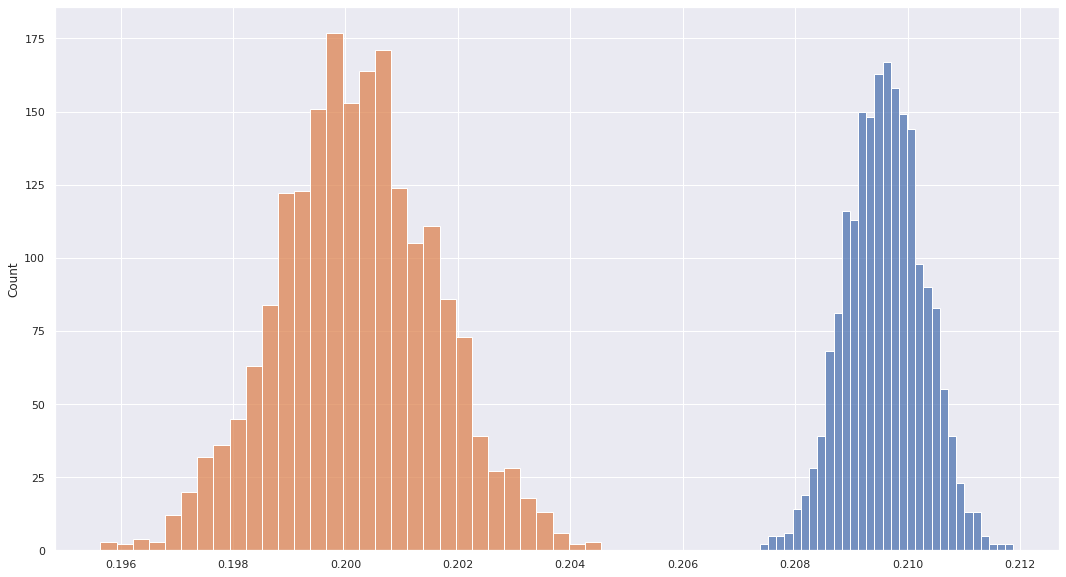

In [49]:
sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

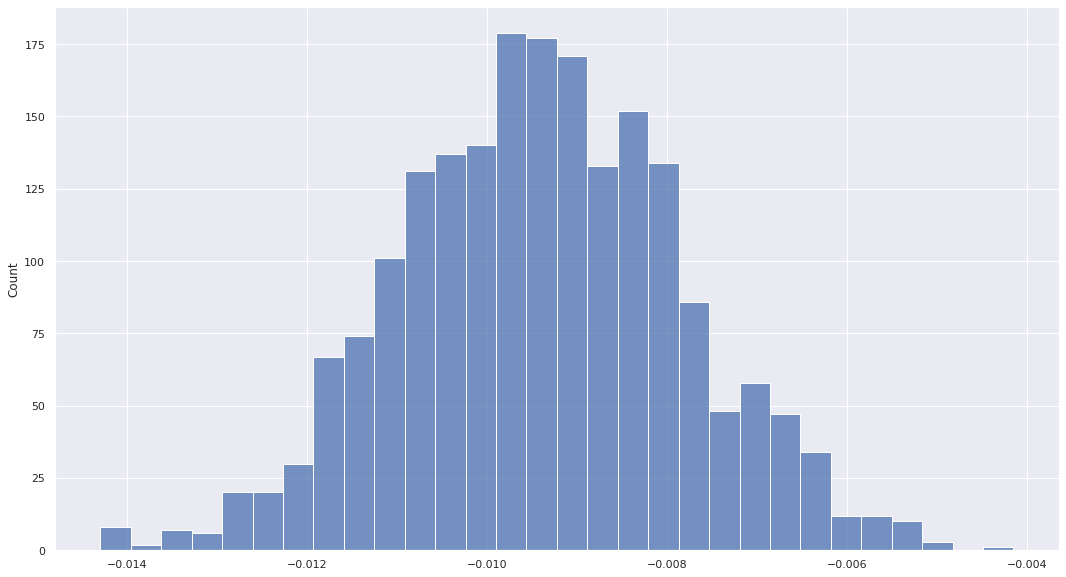

In [50]:
#Разница между глобальными CTR
sns.histplot(ctr2 - ctr1)

Согласно пуассоновскому бустеру гистограмма разности не пересекает ноль и значения отрицательные. 
Поэтому ctr группы 2 с новым алгоритмом ниже ctr контрольной группы 1.

## Выводы
### CTR группы 2 с новым алгоритмом ниже CTR контрольной группы 1.

В ходе тестирования получили интересный результат. На графике видно, что у большой части пользователей ctr стал значительно меньше (первый горб), а у другой части ctr стал больше (второй горб). Необходимо дополнительное исследование.

Новый алгоритм рекомендаций постов признаем не эффективным . 

Сейчас расскатывать на всю аудиторию новый алгоритм рекоменадций постов не допустимо!